In [280]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
import catboost
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
import optuna
import warnings
warnings.filterwarnings('ignore')

In [240]:
# cargamos el dataset
bdif = pd.read_excel("bdif_modelo_2017.xlsx")
bdif.head()

,parte,año,cod_com,cod_prov,probignicion,detectadopor,fecha,combustible,fuego,lugar,...,velmedia,racha,sol,hrmedia,fwi,denpoblacion,denincendios,horario,areaquemada,claseincendio
0,1974020249,1974,11,2,0.0,otros,1974-04-25,bosques,sup_cop,otros,...,6.1,11.900000,9.5,56.0,12.101361,0.041339,0.000020,Tarde,8.0,incendio
1,1974020374,1974,11,2,0.0,otros,1974-05-19,bosques,sup_cop,excursionistas,...,6.4,13.100000,10.9,53.0,69.039001,0.334612,0.000013,Tarde,0.3,conato
2,1974020459,1974,11,46,0.0,agente_forestal,1974-06-11,bosques,sup_cop,otros,...,3.6,11.100000,3.3,71.0,11.837668,0.084859,0.000022,Mañana,0.6,conato
3,1974022274,1974,11,2,0.0,otros,1974-09-11,bosques,sup_cop,autovia_carretera,...,5.0,7.116667,8.9,63.0,42.358257,0.139880,0.000123,Tarde,2.0,incendio
4,1974022457,1974,11,2,0.0,agente_forestal,1974-10-01,mat_bos,sup_cop,otros,...,4.7,14.400000,9.3,45.0,15.454229,0.035034,0.000068,Mañana,0.5,conato


In [241]:
# para poder recuperarlo
bdif_save = bdif.copy()

### Aplicamos el mapeo de clases para la variable objetivo

In [242]:
# Crear un diccionario para mapear las clases a valores específicos
mapeo_clases = {'conato': 0, 'incendio': 1, 'gif': 2}

# Aplicar el mapeo a la columna 'claseincendio'
bdif['claseincendio'] = bdif['claseincendio'].map(mapeo_clases)

# Verificar el resultado
bdif['claseincendio'].value_counts()

claseincendio
0    339190
1    237218
2      2008
Name: count, dtype: int64

In [243]:
# Separamos el dataset para usarlo para el entrenamiento del modelo
bdif_modelo = bdif[bdif['año'] <= 2016]
bdif_modelo.shape

(570372, 30)

### Preprocesamiento de los datos

In [244]:
# Seleccionamos las variables numéricas y categóricas 
numericas = ['probignicion', 'altitud', 'lon', 'lat', 'prec', 'tmax', 'dir', 'velmedia',
             'racha', 'sol', 'hrmedia', 'denpoblacion', 'denincendios', 'fwi']
categoricas = ['detectadopor', 'combustible', 'fuego', 'lugar', 'mes', 'dia', 'horario']

# Aplicamos las transformaciones para cada tipo de variable
prep = ColumnTransformer(transformers=[
        ('num', MinMaxScaler(), numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop=None, sparse_output=False), categoricas),])

# Creamos el pipeline
pipeline = Pipeline(steps=[('prep', prep)])

# Introducimos los datos de entrada
X = bdif_modelo.drop(columns=['claseincendio'])

# Ajustar el Pipeline a los datos y transformar
X_prep = pipeline.fit_transform(X)

# Lo pasamos a dataframe
X_prepdf = pd.DataFrame(X_prep, columns=pipeline.named_steps['prep'].get_feature_names_out())

# Hay que convertir las columnas categoricas a enteros
dummies = X_prepdf.filter(regex='^cat').columns
X_prepdf[dummies] = X_prepdf[dummies].astype(int)

# Eliminamos los prefijos
X_prepdf.columns = X_prepdf.columns.str.replace(r'^(num__|cat__)', '', regex=True)

# Reconstruimos el dataset y lo mostramos
X_prepdf['claseincendio'] = bdif_modelo['claseincendio']
bdif_reconstruido = X_prepdf.copy()
bdif_reconstruido.head()

,probignicion,altitud,lon,lat,prec,tmax,dir,velmedia,racha,sol,...,mes_septiembre,dia_festivo,dia_lab_vis_fes,dia_laborable,dia_sabado,horario_Madrugada,horario_Mañana,horario_Noche,horario_Tarde,claseincendio
0,0.0,0.517710,0.703490,0.663822,0.0,0.462795,0.805556,0.194268,0.218750,0.637584,...,0,0,0,1,0,0,0,0,1,1
1,0.0,0.335891,0.731106,0.672918,0.0,0.637024,0.500000,0.203822,0.240809,0.731544,...,0,1,0,0,0,0,0,0,1,0
2,0.0,0.351240,0.760152,0.707177,0.0,0.571688,0.250000,0.114650,0.204044,0.221477,...,0,0,0,1,0,0,1,0,0,0
3,0.0,0.664109,0.699029,0.672143,0.0,0.662432,0.418981,0.159236,0.130821,0.597315,...,1,0,0,1,0,0,0,0,1,1
4,0.0,0.410272,0.714636,0.675420,0.0,0.575318,0.694444,0.149682,0.264706,0.624161,...,0,0,0,1,0,0,1,0,0,0


In [250]:
# Tomamos el dataset con las caracteristicas que nos interesan
bdif_reconstruido = bdif_reconstruido[['denincendios', 'tmax', 'denpoblacion', 'lon', 'lat', 'fuego_sup_cop', 'fwi', 'hrmedia', 'altitud',
          'fuego_superficie', 'sol', 'racha', 'dir', 'velmedia', 'probignicion', 'combustible_matorrales',
          'combustible_mat_bos', 'prec', 'combustible_pas_mat_bos', 'detectadopor_agente_forestal', 'horario_Noche',
          'horario_Tarde', 'lugar_otros', 'detectadopor_vigilante_fijo', 'dia_laborable', 'mes_agosto',
          'detectadopor_llamada_particular', 'lugar_autovia_carretera', 'lugar_senda', 'detectadopor_otros', 'dia_festivo',
          'mes_septiembre', 'combustible_pastizales', 'dia_sabado', 'combustible_bosques', 'horario_Mañana', 'claseincendio']]
bdif_reconstruido.head()

,denincendios,tmax,denpoblacion,lon,lat,fuego_sup_cop,fwi,hrmedia,altitud,fuego_superficie,...,lugar_autovia_carretera,lugar_senda,detectadopor_otros,dia_festivo,mes_septiembre,combustible_pastizales,dia_sabado,combustible_bosques,horario_Mañana,claseincendio
0,0.000014,0.462795,0.000166,0.703490,0.663822,1,0.068724,0.541667,0.517710,0,...,0,0,1,0,0,0,0,1,0,1
1,0.000006,0.637024,0.001347,0.731106,0.672918,1,0.421203,0.510417,0.335891,0,...,0,0,1,1,0,0,0,1,0,0
2,0.000018,0.571688,0.000341,0.760152,0.707177,1,0.067092,0.697917,0.351240,0,...,0,0,0,0,0,0,0,1,1,0
3,0.000145,0.662432,0.000563,0.699029,0.672143,1,0.256033,0.614583,0.664109,0,...,1,0,1,0,1,0,0,1,0,1
4,0.000076,0.575318,0.000141,0.714636,0.675420,1,0.089480,0.427083,0.410272,0,...,0,0,0,0,0,0,0,0,1,0


### ANN con el dataset completo

In [246]:
# Separamos variables descriptivas de 
X = bdif.drop(['claseincendio'], axis=1)
y = bdif['claseincendio']

### ANN con el dataset submuestreado con ENN + Tomek Links

In [247]:
bdif_enn_tomek = pd.read_excel("bdif_submuestreado.xlsx")
bdif_enn_tomek.head()

,denincendios,tmax,denpoblacion,lon,lat,fuego_sup_cop,fwi,hrmedia,altitud,fuego_superficie,...,lugar_autovia_carretera,lugar_senda,detectadopor_otros,dia_festivo,mes_septiembre,combustible_pastizales,dia_sabado,combustible_bosques,horario_Mañana,claseincendio
0,0.014306,0.618875,0.000183,0.559100,0.802846,0,0.265486,0.572917,0.543093,1,...,0,0,0,0,0,1,0,0,0,0
1,0.000358,0.542650,0.000068,0.523174,0.647512,0,0.000000,0.656250,0.418536,1,...,0,1,1,0,0,1,1,0,0,0
2,0.000269,0.802178,0.000060,0.574670,0.718691,0,0.378725,0.427083,0.236128,1,...,0,0,0,0,0,0,0,0,0,0
3,0.000112,0.802178,0.000010,0.587270,0.722982,0,0.378725,0.427083,0.257379,1,...,0,0,0,0,0,0,0,0,0,0
4,0.000112,0.802178,0.000010,0.587270,0.722982,0,0.378725,0.427083,0.257379,1,...,0,0,0,0,0,0,0,0,0,0


In [251]:
print(bdif_enn_tomek['claseincendio'].value_counts())

claseincendio
0    70482
1    26177
2     1966
Name: count, dtype: int64


### Dataset submuestreado de clases mayoritarias y reducido aleatoriamente a la clase minoritaria

En este caso reducimos el número de muestras de las clases mayoritarias, conatos e incendios. Aunque estan siendo muy bien identificadas, el hecho de que tengamos tantas muestras en favor de esas clases, hace que la clase más importante no esté siendo clasificada, por ello, trataremos de balancear el dataset. 

Reducimos aleatoriamente las muestras de las clases conatos e incendios a un número fijo de muestras.

In [252]:
# Submuestreo aleatorio {0: int(2*y.value_counts()[2]), 1: int(1.5*y.value_counts()[2])}
rus = RandomUnderSampler(sampling_strategy={0: int(1.5*y.value_counts()[2]), 1: int(1.5*y.value_counts()[2])}, random_state=42)

X = bdif_enn_tomek.drop(['claseincendio'], axis=1)
y = bdif_enn_tomek['claseincendio']

X_res, y_res = rus.fit_resample(X, y)

bdif_sub = pd.concat([X_res, y_res], axis=1)
print(bdif_sub['claseincendio'].value_counts())

claseincendio
0    3012
1    3012
2    1966
Name: count, dtype: int64


Realizamos el sobremuestreo del gif con RandomOverSampler para balancear el dataset y tratar de acercarnos al número de muestras de las clases mayoritarias. El sobremuestreo lo realizamos sólo en el entrenamiento, el conjunto de test se deja intacto.

### Incrementamos la clase gif con SMOTE

In [281]:
X = bdif_sub.drop(['claseincendio'], axis=1)
y = bdif_sub['claseincendio']

X_train_sob, X_test, y_train_sob, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train_sob, y_train_sob)

# Comprobamos el balanceo de clases
print(f"Distribución de clases en el conjunto de entrenamiento después de SMOTE: {Counter(y_train)}")
print(f"Distribución de clases en el conjunto de test: {Counter(y_test)}")

Distribución de clases en el conjunto de entrenamiento después de SMOTE: Counter({1: 2434, 0: 2434, 2: 2434})
Distribución de clases en el conjunto de test: Counter({0: 631, 1: 578, 2: 389})


In [284]:
X_train.head()

,denincendios,tmax,denpoblacion,lon,lat,fuego_sup_cop,fwi,hrmedia,altitud,fuego_superficie,...,detectadopor_llamada_particular,lugar_autovia_carretera,lugar_senda,detectadopor_otros,dia_festivo,mes_septiembre,combustible_pastizales,dia_sabado,combustible_bosques,horario_Mañana
0,0.004667,0.353902,0.000537,0.482556,0.938327,0,0.000000,0.798569,0.384888,1,...,0,0,0,0,0,0,0,0,0,0
1,0.003255,0.702359,0.000325,0.737493,0.923999,0,0.070350,0.541667,0.369540,1,...,0,0,0,1,0,0,0,0,0,0
2,0.035308,0.551724,0.001690,0.594214,0.980107,0,0.126921,0.710863,0.005313,1,...,1,0,0,0,0,1,0,0,0,0
3,0.002535,0.782214,0.000750,0.444864,0.885092,1,0.072289,0.721669,0.246163,0,...,0,0,0,0,0,0,0,1,0,0
4,0.097746,0.435572,0.012778,0.404030,0.925837,0,0.000000,0.682639,0.005313,1,...,1,0,0,0,0,0,0,0,0,0


### Bloque cálculos

In [285]:
# Crear el modelo
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    verbose=100
)

# Entrenar el modelo
model.fit(X_train, y_train)

# Predecir
y_pred = model.predict(X_test)

0:	learn: 1.0589170	total: 146ms	remaining: 1m 12s
100:	learn: 0.4519911	total: 670ms	remaining: 2.65s
200:	learn: 0.3834044	total: 1.16s	remaining: 1.73s
300:	learn: 0.3406022	total: 1.66s	remaining: 1.1s
400:	learn: 0.3077033	total: 2.14s	remaining: 528ms
499:	learn: 0.2802659	total: 2.63s	remaining: 0us


In [286]:
# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 83.54%


In [288]:
# Predicciones
y_pred_proba = model.predict_proba(X_test)
# Mostrar el reporte de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       631
           1       0.83      0.78      0.81       578
           2       0.73      0.75      0.74       389

    accuracy                           0.84      1598
   macro avg       0.82      0.82      0.82      1598
weighted avg       0.83      0.84      0.83      1598



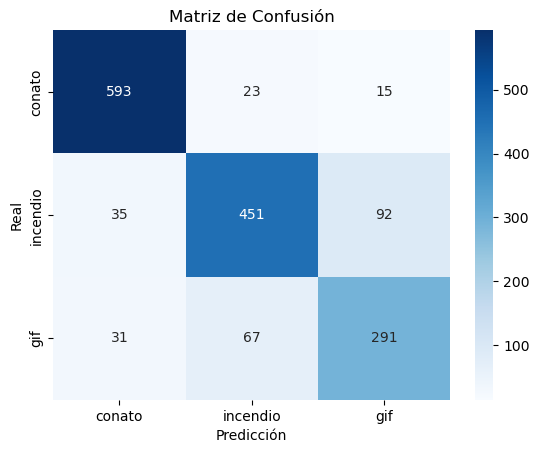

In [289]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# Guardamos las etiquetas reales
etiquetas= ['conato', 'incendio', 'gif']

# Creamos y mostramos la matriz
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas, yticklabels=etiquetas)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

### Optimización con Optuna

In [294]:
def objective(trial):

    iterations = trial.suggest_int('iterations', 100, 1000)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1)
    depth = trial.suggest_int('depth', 3, 15)
    
    model = CatBoostClassifier(iterations=iterations, learning_rate=learning_rate, depth=depth, verbose=0)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    f1 = f1_score(y_test, y_pred, average='macro')
    
    return f1

In [293]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10) 

print(f"Best trial: {study.best_trial.value}")
print("Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

[I 2024-12-15 21:08:56,336] A new study created in memory with name: no-name-e7dfe205-ef52-4059-b576-f42a9ed82d16
[I 2024-12-15 21:12:35,712] Trial 0 finished with value: 0.8123295756428558 and parameters: {'iterations': 200, 'learning_rate': 0.04938233247175637, 'depth': 14}. Best is trial 0 with value: 0.8123295756428558.
[I 2024-12-15 21:12:40,719] Trial 1 finished with value: 0.8273320768386422 and parameters: {'iterations': 538, 'learning_rate': 0.06531706981925675, 'depth': 7}. Best is trial 1 with value: 0.8273320768386422.
[I 2024-12-15 21:13:36,052] Trial 2 finished with value: 0.8321480707503043 and parameters: {'iterations': 783, 'learning_rate': 0.03780075620527163, 'depth': 10}. Best is trial 2 with value: 0.8321480707503043.
[I 2024-12-15 21:13:58,974] Trial 3 finished with value: 0.8079474972806548 and parameters: {'iterations': 323, 'learning_rate': 0.010083398934314161, 'depth': 10}. Best is trial 2 with value: 0.8321480707503043.
[I 2024-12-15 21:15:58,343] Trial 4 fi

KeyboardInterrupt: 

In [296]:
best_params = study.best_trial.params

best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train, y_train)

y_pred_final = best_model.predict(X_test)

0:	learn: 1.0399078	total: 149ms	remaining: 2m 2s
1:	learn: 0.9805240	total: 287ms	remaining: 1m 57s
2:	learn: 0.9288528	total: 425ms	remaining: 1m 55s
3:	learn: 0.8852498	total: 555ms	remaining: 1m 53s
4:	learn: 0.8445518	total: 695ms	remaining: 1m 53s
5:	learn: 0.8086793	total: 842ms	remaining: 1m 54s
6:	learn: 0.7755188	total: 982ms	remaining: 1m 54s
7:	learn: 0.7456924	total: 1.11s	remaining: 1m 53s
8:	learn: 0.7209405	total: 1.25s	remaining: 1m 53s
9:	learn: 0.6968730	total: 1.39s	remaining: 1m 52s
10:	learn: 0.6761427	total: 1.53s	remaining: 1m 52s
11:	learn: 0.6536580	total: 1.67s	remaining: 1m 52s
12:	learn: 0.6344510	total: 1.82s	remaining: 1m 53s
13:	learn: 0.6181122	total: 1.96s	remaining: 1m 53s
14:	learn: 0.6025719	total: 2.11s	remaining: 1m 53s
15:	learn: 0.5893437	total: 2.25s	remaining: 1m 53s
16:	learn: 0.5738538	total: 2.38s	remaining: 1m 52s
17:	learn: 0.5601855	total: 2.52s	remaining: 1m 52s
18:	learn: 0.5477431	total: 2.65s	remaining: 1m 52s
19:	learn: 0.5357454	to

In [298]:
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       631
           1       0.83      0.78      0.81       578
           2       0.73      0.75      0.74       389

    accuracy                           0.84      1598
   macro avg       0.82      0.82      0.82      1598
weighted avg       0.83      0.84      0.83      1598



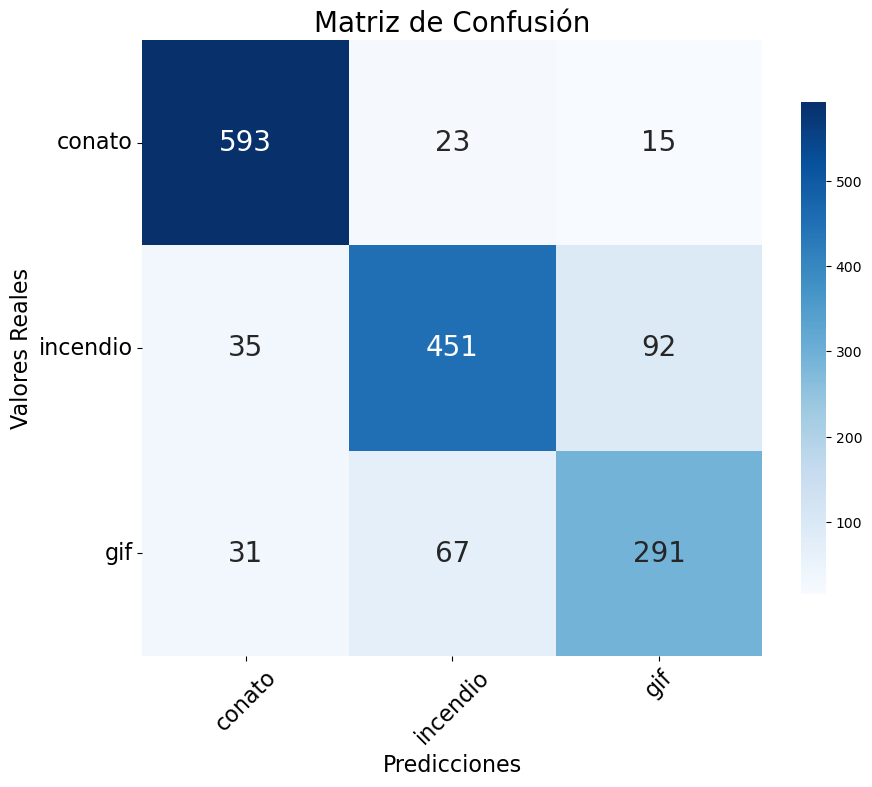

In [297]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# Etiquetas de las clases
etiquetas = ['conato', 'incendio', 'gif']

plt.figure(figsize=(10, 8))

# Visualizamos la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=etiquetas, yticklabels=etiquetas,
            annot_kws={"size": 20}, cbar_kws={"shrink": 0.8})

plt.title("Matriz de Confusión", fontsize=20)
plt.xlabel("Predicciones", fontsize=16)
plt.ylabel("Valores Reales", fontsize=16)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(rotation=0, fontsize=16)

# Mostramos la gráfica
plt.show()

In [299]:
import joblib
joblib.dump(best_model, 'best_CatBoost_model.pkl')

['best_CatBoost_model.pkl']

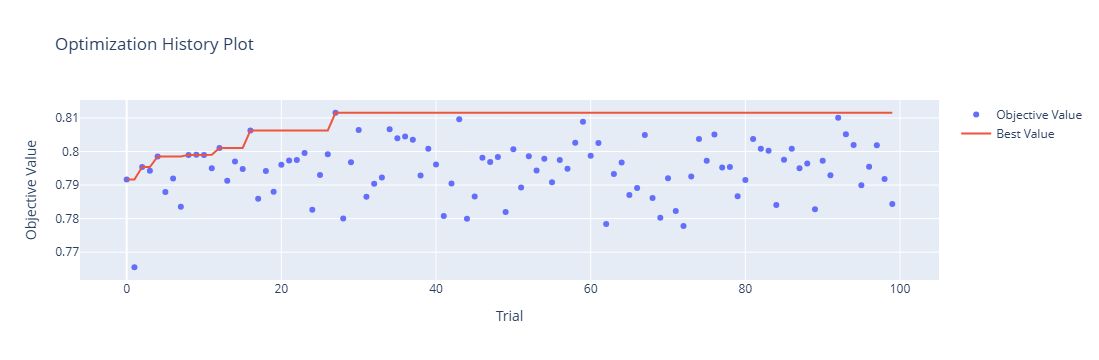

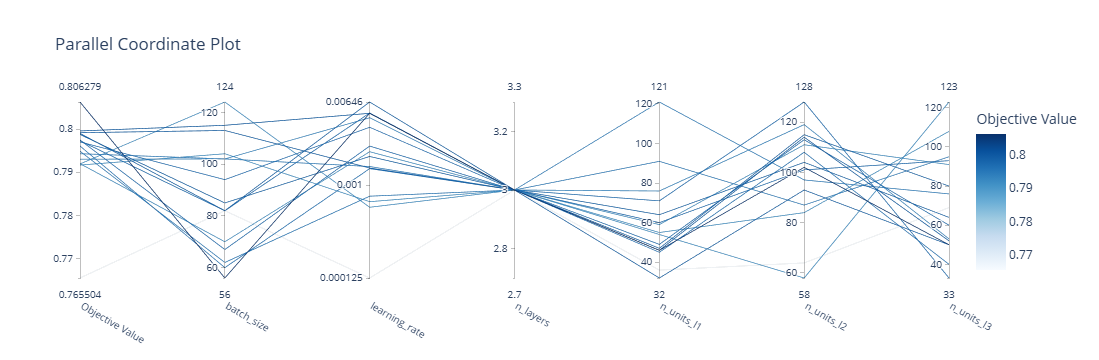

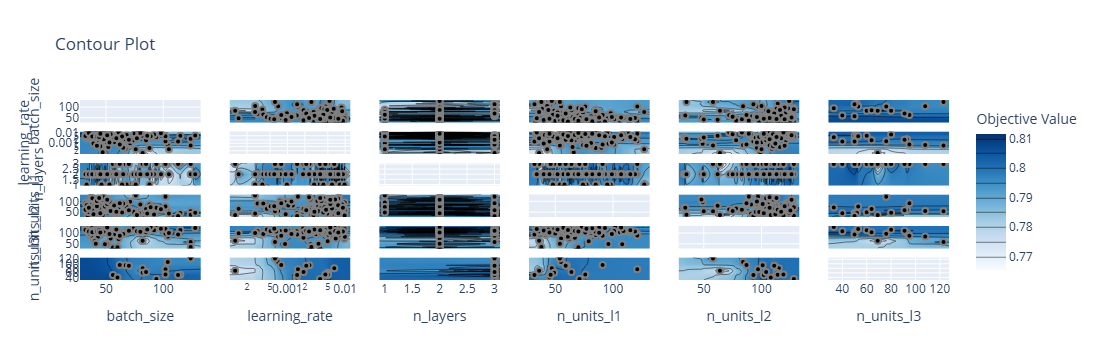

In [167]:
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_parallel_coordinate(study).show()
optuna.visualization.plot_contour(study).show()

### Año 2017

In [301]:
bdif_2017 = bdif[bdif['año'] == 2017]
bdif_2017.shape

(8044, 30)

In [302]:
X = bdif_2017.drop(['claseincendio'], axis=1)
y = bdif_2017['claseincendio']

rus = RandomUnderSampler(sampling_strategy='auto', random_state=36)

X_sub, y_sub = rus.fit_resample(X, y)

bdif_2017 = pd.concat([X_sub, y_sub], axis=1)

print(bdif_2017['claseincendio'].value_counts())

claseincendio
0    42
1    42
2    42
Name: count, dtype: int64


In [303]:
# Separamos las variables descriptivas de la variable objetivo
X_2017 = bdif_2017.drop(columns=['claseincendio'])
y_2017 = bdif_2017['claseincendio']

# le pasamos el pipeline a los datos de 2017
X_2017 = pipeline.transform(X_2017)

In [304]:
# Lo pasamos a dataframe
X_2017 = pd.DataFrame(X_2017, columns=pipeline.named_steps['prep'].get_feature_names_out())

# Hay que convertir las columnas categoricas a enteros
dummies = X_2017.filter(regex='^cat').columns
X_2017[dummies] = X_2017[dummies].astype(int)

# Eliminamos los prefijos
X_2017.columns = X_2017.columns.str.replace(r'^(num__|cat__)', '', regex=True)

# Mostrar el resultado
X_2017.head()

,probignicion,altitud,lon,lat,prec,tmax,dir,velmedia,racha,sol,...,mes_octubre,mes_septiembre,dia_festivo,dia_lab_vis_fes,dia_laborable,dia_sabado,horario_Madrugada,horario_Mañana,horario_Noche,horario_Tarde
0,0.259839,0.116883,0.528561,0.971318,0.0,0.637024,0.333333,0.035032,0.086397,0.353356,...,1,0,0,0,0,1,0,0,0,1
1,0.088348,0.147580,0.541342,0.699433,0.0,0.825771,0.861111,0.035032,0.097426,0.765101,...,0,0,0,0,1,0,0,0,0,1
2,0.029399,0.380165,0.459479,0.897975,0.0,0.607985,0.585859,0.089172,0.178309,0.468960,...,1,0,0,0,1,0,0,0,0,1
3,0.454518,0.115702,0.739471,0.962862,0.0,0.644283,0.472222,0.025478,0.117647,0.513849,...,0,0,1,0,0,0,0,0,1,0
4,0.173057,0.365998,0.571168,0.574255,0.0,0.773140,0.777778,0.054140,0.152574,0.684564,...,1,0,0,0,1,0,0,1,0,0


In [305]:
# Filtramos la selección de características
X_2017 = X_2017[['denincendios', 'tmax', 'denpoblacion', 'lon', 'lat', 'fuego_sup_cop', 'fwi', 'hrmedia', 'altitud',
          'fuego_superficie', 'sol', 'racha', 'dir', 'velmedia', 'probignicion', 'combustible_matorrales',
          'combustible_mat_bos', 'prec', 'combustible_pas_mat_bos', 'detectadopor_agente_forestal', 'horario_Noche',
          'horario_Tarde', 'lugar_otros', 'detectadopor_vigilante_fijo', 'dia_laborable', 'mes_agosto',
          'detectadopor_llamada_particular', 'lugar_autovia_carretera', 'lugar_senda', 'detectadopor_otros', 'dia_festivo',
          'mes_septiembre', 'combustible_pastizales', 'dia_sabado', 'combustible_bosques', 'horario_Mañana']]
X_2017.shape

(126, 36)

In [311]:
# Realizar predicciones con el modelo
y_pred_2017 = best_model.predict(X_2017)

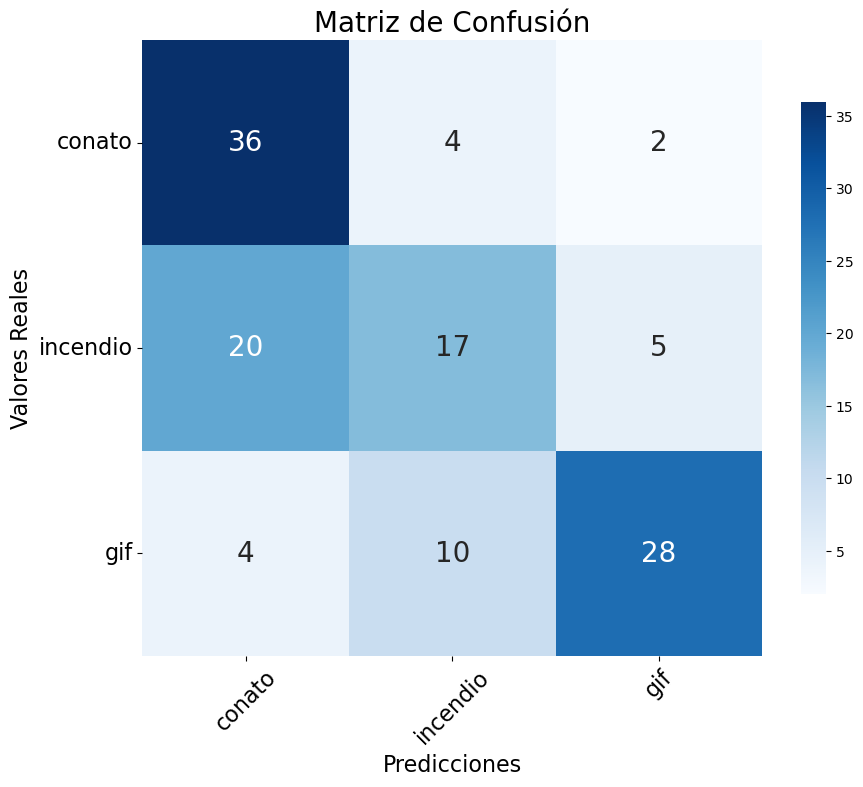

In [312]:
cm = confusion_matrix(y_2017, y_pred_2017,labels=[0, 1, 2])

# Etiquetas de las clases
etiquetas = ['conato', 'incendio', 'gif']

plt.figure(figsize=(10, 8))

# Visualizamos la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=etiquetas, yticklabels=etiquetas,
            annot_kws={"size": 20}, cbar_kws={"shrink": 0.8})

plt.title("Matriz de Confusión", fontsize=20)
plt.xlabel("Predicciones", fontsize=16)
plt.ylabel("Valores Reales", fontsize=16)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(rotation=0, fontsize=16)

# Mostramos la gráfica
plt.show()

In [313]:
# Mostramos el informe
print(classification_report(y_2017, y_pred_2017, target_names=['conato', 'incendio', 'gif']))

              precision    recall  f1-score   support

      conato       0.60      0.86      0.71        42
    incendio       0.55      0.40      0.47        42
         gif       0.80      0.67      0.73        42

    accuracy                           0.64       126
   macro avg       0.65      0.64      0.63       126
weighted avg       0.65      0.64      0.63       126



@inproceedings{akiba2019optuna,
  title={{O}ptuna: A Next-Generation Hyperparameter Optimization Framework},
  author={Akiba, Takuya and Sano, Shotaro and Yanase, Toshihiko and Ohta, Takeru and Koyama, Masanori},
  booktitle={The 25th ACM SIGKDD International Conference on Knowledge Discovery \& Data Mining},
  pages={2623--2631},
  year={2019}
}